# 실생활 예제로 PINNs 학습하기

## 1. 문제 설명: 온도 변화 예측

실생활에서 중요한 문제 중 하나는 온도 변화 예측입니다.
예를 들어, 뜨거운 물이 주변 환경과 열 교환을 통해 식는 과정을 분석하는 것입니다.

뉴턴의 냉각 법칙에 따르면:

$$
\frac{dT}{dt} = -k(T - T_{\text{env}})
$$

여기서:
$$
\begin{aligned}
& T : \text{물체의 온도} \\
& T_{\text{env}} : \text{환경의 온도} \\
& k : \text{냉각 상수 (열 교환 속도를 나타냄)}
\end{aligned}
$$

초기 조건: $$ T(0) = T_0 $$.  
이 방정식을 PINNs를 사용해 풀어보겠습니다.

---

```python
# 필요한 라이브러리 불러오기
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
```

---

## 2. 참 해(Solution) 정의

뉴턴의 냉각 법칙의 참 해는 다음과 같습니다:

$$
T(t) = T_{\text{env}} + (T_0 - T_{\text{env}}) e^{-kt}
$$

```python
# 참 해 정의
def true_solution_temp(t, T_env, T_0, k):
    return T_env + (T_0 - T_env) * np.exp(-k * t)
```

---

## 3. PINN 모델 정의

```python
# PINN 모델 정의
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)
```

---

## 4. 손실 함수 정의

손실 함수는 뉴턴의 냉각 법칙을 충족하도록 설계됩니다. 초기 조건을 포함합니다.

$$
\frac{dT}{dt} = -k(T - T_{\text{env}}) \rightarrow
Loss = \Big| \frac{dT_{model}}{dt} + k(T_{model} - T_{\text{env}}) \Big|^2 +
|T_{model} - T_0|^2
$$


```python
# 수정된 손실 함수 정의
def loss_temp_with_ic(model, t, T_env, T_0, k):
    # ODE Loss 계산
    t.requires_grad = True
    T = model(t)
    dT_dt = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    ode_loss = torch.mean((dT_dt + k * (T - T_env)) ** 2)
    
    # 초기 조건 손실 계산
    t0 = torch.tensor([[0.0]], dtype=torch.float32)  # 초기 시간 0초
    T0_pred = model(t0)  # 모델이 예측한 초기 온도
    ic_loss = torch.mean((T0_pred - T_0) ** 2)  # \( T(0) = T_0 \)의 오차
    
    return ode_loss + ic_loss
```

---

## 5. 모델 학습 함수

```python
# 모델 학습 함수
def train_model(model, t_train, loss_fn, T_env, T_0, k, epochs=1000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train, T_env, T_0, k)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
```

---

## 6. 학습 및 결과 시각화

```python
# 초기 조건 및 매개변수 설정
T_env = 25  # 환경 온도 (예: 25°C)
T_0 = 100   # 초기 온도 (예: 100°C)
k = 0.1     # 냉각 상수

# 학습 데이터 생성
t_train = torch.linspace(0, 10, 100).view(-1, 1)  # 0초부터 10초까지

# PINN 모델 학습
model_temp = PINN()
train_model(model_temp, t_train, loss_temp_with_ic, T_env, T_0, k, epochs=1000)

# 결과 시각화
t_test = np.linspace(0, 10, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
T_pred = model_temp(t_test_tensor).detach().numpy()

# 참 해 계산
T_true = true_solution_temp(t_test, T_env, T_0, k)

plt.plot(t_test, T_true, label="True Solution")
plt.plot(t_test, T_pred, label="PINN Solution", linestyle='dashed')
plt.title("Temperature Cooling Prediction")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()



In [7]:
# 필요한 라이브러리 불러오기
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [8]:
# 참 해 정의
def true_solution_temp(t, T_env, T_0, k):
    return T_env + (T_0 - T_env) * np.exp(-k * t)

In [9]:
# PINN 모델 정의
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.layers(x)


In [10]:
# 수정된 손실 함수 정의
def loss_temp_with_ic(model, t, T_env, T_0, k):
    # ODE Loss 계산
    t.requires_grad = True
    T = model(t)
    dT_dt = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    ode_loss = torch.mean((dT_dt + k * (T - T_env)) ** 2)

    # 초기 조건 손실 계산
    t0 = torch.tensor([[0.0]], dtype=torch.float32)  # 초기 시간 0초
    T0_pred = model(t0)  # 모델이 예측한 초기 온도
    ic_loss = torch.mean((T0_pred - T_0) ** 2)  # \( T(0) = T_0 \)의 오차

    return ode_loss + ic_loss


In [13]:
# 모델 학습 함수
def train_model(model, t_train, loss_fn, T_env, T_0, k, epochs=2000, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, t_train, T_env, T_0, k)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 9953.6250
Epoch 100, Loss: 5854.9170
Epoch 200, Loss: 3390.4592
Epoch 300, Loss: 1852.8225
Epoch 400, Loss: 929.1403
Epoch 500, Loss: 429.9853
Epoch 600, Loss: 181.9659
Epoch 700, Loss: 70.2702
Epoch 800, Loss: 24.8956
Epoch 900, Loss: 8.2943
Epoch 1000, Loss: 2.7606
Epoch 1100, Loss: 1.0158
Epoch 1200, Loss: 0.4573
Epoch 1300, Loss: 0.2250
Epoch 1400, Loss: 0.0958
Epoch 1500, Loss: 0.0326
Epoch 1600, Loss: 0.0095
Epoch 1700, Loss: 0.0032
Epoch 1800, Loss: 0.0015
Epoch 1900, Loss: 0.0010


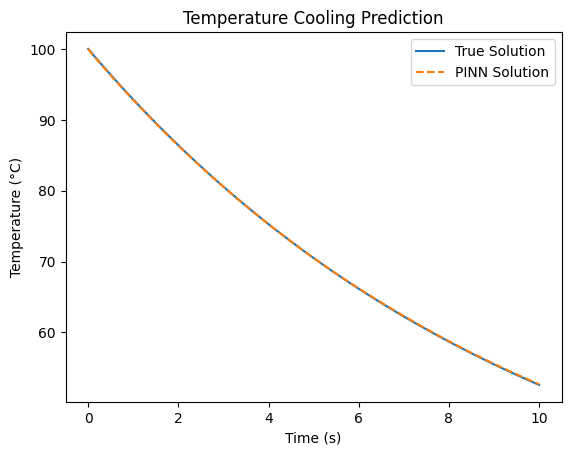

In [14]:
# 초기 조건 및 매개변수 설정
T_env = 25  # 환경 온도 (예: 25°C)
T_0 = 100   # 초기 온도 (예: 100°C)
k = 0.1     # 냉각 상수

# 학습 데이터 생성
t_train = torch.linspace(0, 10, 100).view(-1, 1)  # 0초부터 10초까지

# PINN 모델 학습
model_temp = PINN()
train_model(model_temp, t_train, loss_temp_with_ic, T_env, T_0, k, epochs=2000)

# 결과 시각화
t_test = np.linspace(0, 10, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).view(-1, 1)
T_pred = model_temp(t_test_tensor).detach().numpy()

# 참 해 계산
T_true = true_solution_temp(t_test, T_env, T_0, k)

plt.plot(t_test, T_true, label="True Solution")
plt.plot(t_test, T_pred, label="PINN Solution", linestyle='dashed')
plt.title("Temperature Cooling Prediction")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()
